<a href="https://colab.research.google.com/github/theokitsberg/Listening-Llama/blob/main/building%20dAvId.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# --- Cell 1: Install and Import Libraries ---

# Install Anthropics Claude API SDK if needed
!pip install anthropic -q

# Core imports
import anthropic
import pandas as pd
import random
import time
import json
from datetime import datetime

print("✅ Libraries installed and imported.")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 245.3/245.3 kB 12.8 MB/s eta 0:00:00
✅ Libraries installed and imported.


In [3]:
# --- Cell 2: Set Up Claude API Key and Model Config ---

# @title Claude API Setup
# (You can run this cell safely; your key stays private inside the notebook.)

import getpass

# Enter your Claude API Key securely
api_key = getpass.getpass("Enter your Claude API key:")

# Initialize the Claude (Anthropic) client
client = anthropic.Anthropic(
    api_key=api_key
)

# Choose Claude Model
model_name = "claude-3-7-sonnet-20250219"

print(f"✅ Connected to Claude model: {model_name}")


Enter your Claude API key:··········
✅ Connected to Claude model: claude-3-7-sonnet-20250219


In [4]:
# --- Cell 3: Upload the Essays Dataset Manually ---

from google.colab import files
import io

# Upload Essays.csv manually
uploaded = files.upload()

# Find uploaded filename
filename = list(uploaded.keys())[0]

# Load using pandas
essays_df = pd.read_csv(io.BytesIO(uploaded[filename]))

# Check the first few rows to make sure it's loaded properly
print("✅ Essays loaded:")
display(essays_df.head())

# Convert to list
real_essays = essays_df['essay_text'].tolist()

# Split essays into Training and Holdout Sets
# Reserve last 3 for holdout evaluation
training_essays = real_essays[:-3]
holdout_essays = real_essays[-3:]

print(f"Training Essays: {len(training_essays)} | Holdout Essays: {len(holdout_essays)}")


Saving Essays.csv to Essays.csv
✅ Essays loaded:


,id,essay_text
0,1,Does the apparent falsehood of past theories g...
1,2,Is Cartwright’s capacity account of regulariti...
2,3,What do you see as the most plausible version ...
3,4,What does it mean to say that the probability ...
4,5,Does the progress of science always involve im...


Training Essays: 18 | Holdout Essays: 3


In [5]:
# --- Cell 4: Load Philosophical Topics ---

# List of philosophical essay topics
philosophy_topics = [
    # Metaphysics and Philosophy of Mind
    "Is free will compatible with determinism?",
    "Are personal identities continuous over time?",
    "Is consciousness fundamentally physical or non-physical?",
    "Can non-human animals possess minds?",
    "Do abstract objects, like numbers, really exist?",

    # Ethics and Political Philosophy
    "Are moral facts objective or subjective?",
    "Can a perfectly just society ever exist?",
    "Is democracy the best form of government?",
    "Are individuals morally responsible for the actions of the groups they belong to?",
    "Is equality more important than liberty?",

    # Epistemology and Theory of Knowledge
    "Can we ever truly know anything with certainty?",
    "Is perception a reliable guide to reality?",
    "Is testimony from others a basic source of knowledge?",
    "How should we deal with disagreement among epistemic peers?",
    "Is skepticism a rational position?",

    # Philosophy of Science
    "Does scientific progress bring us closer to truth?",
    "Are scientific theories inventions or discoveries?",
    "Should science aim for truth or for usefulness?",
    "Can social sciences be as rigorous as natural sciences?",
    "What distinguishes science from pseudoscience?",

    # Aesthetics and Philosophy of Art
    "Can art be immoral?",
    "Is beauty subjective or objective?",
    "Can a work of art be understood independently of its historical context?",
    "Should artists have moral responsibilities?",
    "Can anything be considered 'art'?",

    # General Philosophy
    "Is it possible to have a meaningful life without belief in a higher power?",
    "Can language ever fully capture reality?",
    "Should future generations have rights?",
    "Is progress always desirable?",
    "What makes an action morally praiseworthy?"
]

print(f"✅ Loaded {len(philosophy_topics)} philosophical topics.")


✅ Loaded 30 philosophical topics.


In [17]:
# --- Retry Helper Function ---

import time

def with_retry(func, max_retries=3, wait_seconds=5, **kwargs):
    """Call a function with automatic retries if it fails."""
    for attempt in range(1, max_retries + 1):
        try:
            return func(**kwargs)
        except Exception as e:
            print(f"⚠️ Attempt {attempt} failed with error: {e}")
            if attempt < max_retries:
                print(f"⏳ Waiting {wait_seconds} seconds before retry...")
                time.sleep(wait_seconds)
            else:
                print("❌ Max retries reached. Raising exception.")
                raise e


In [20]:
# ---  Cell 5: Define the Four Core Agents with Smarter Retry ---

# Smarter Retry Helper
def with_retry(func, max_retries=5, base_wait_seconds=5, **kwargs):
    """Call a function with automatic retries if it fails."""
    for attempt in range(1, max_retries + 1):
        try:
            return func(**kwargs)
        except Exception as e:
            error_message = str(e)
            print(f"⚠️ Attempt {attempt} failed with error: {error_message}")

            # Dynamic wait time
            if 'overloaded' in error_message.lower():
                wait_time = base_wait_seconds * 4  # Longer wait if overloaded
                print(f"⏳ Server overloaded. Waiting {wait_time} seconds before retry...")
            else:
                wait_time = base_wait_seconds
                print(f"⏳ Waiting {wait_time} seconds before retry...")

            if attempt < max_retries:
                time.sleep(wait_time)
            else:
                print("❌ Max retries reached. Raising exception.")
                raise e

# 1. Essay Generator (streaming + smarter retry)
def generate_essay(system_prompt, topic):
    def inner_call(system_prompt, topic):
        response = client.messages.create(
            model=model_name,
            max_tokens=30000,
            system=system_prompt,
            messages=[
                {"role": "user", "content": f"Write a philosophical essay on the following topic:\n\n{topic}"}
            ],
            stream=True
        )
        full_text = ""
        for chunk in response:
            if chunk.type == "content_block_delta":
                full_text += chunk.delta.text
        return full_text.strip()

    return with_retry(inner_call, system_prompt=system_prompt, topic=topic)

# 2. Batch Builder (no retry needed)
def build_batch(real_essays, generated_essay, batch_size=5):
    real_sample = random.sample(real_essays, batch_size - 1)
    batch = real_sample + [generated_essay]
    random.shuffle(batch)
    generated_index = batch.index(generated_essay)
    return batch, generated_index

# 3. Discriminator (streaming + smarter retry)
def discriminate(batch):
    def inner_call(batch):
        batch_text = "\n\n".join([f"Essay {i+1}:\n{essay}" for i, essay in enumerate(batch)])
        discriminator_prompt = f"""
You are a style analyst.

You will read {len(batch)} essays, labeled Essay 1 to Essay {len(batch)}.
One essay was written by a different author than the others.

Your task:
1. Identify which essay is different by **essay number** (1 to {len(batch)}).
2. Explain stylistic, argumentative, or tonal differences you observed.
3. Suggest changes that would make the different essay match the others.

Answer in the following format:

Odd Essay Number: [number]
Differences Observed: [text]
Suggested Improvements: [text]

Here are the essays:

{batch_text}
        """
        response = client.messages.create(
            model=model_name,
            max_tokens=20000,
            system="You are a highly intelligent philosophical essay style analyst.",
            messages=[
                {"role": "user", "content": discriminator_prompt}
            ],
            stream=True
        )
        full_text = ""
        for chunk in response:
            if chunk.type == "content_block_delta":
                full_text += chunk.delta.text
        return full_text.strip()

    return with_retry(inner_call, batch=batch)

# 4. Prompt Generator (streaming + smarter retry)
def update_prompt(current_prompt, discriminator_feedback):
    def inner_call(current_prompt, discriminator_feedback):
        prompt_generator_instruction = f"""
You are a prompt engineer helping a philosophical essay writer.

Given the following feedback about a style mismatch, rewrite the system prompt to better match the intended style.
You may make major changes if necessary.

Current System Prompt:
{current_prompt}

Discriminator Feedback:
{discriminator_feedback}

Write a revised system prompt:
        """
        response = client.messages.create(
            model=model_name,
            max_tokens=10000,
            system="You are an expert prompt engineer specializing in style transfer.",
            messages=[
                {"role": "user", "content": prompt_generator_instruction}
            ],
            stream=True
        )
        full_text = ""
        for chunk in response:
            if chunk.type == "content_block_delta":
                full_text += chunk.delta.text
        return full_text.strip()

    return with_retry(inner_call, current_prompt=current_prompt, discriminator_feedback=discriminator_feedback)


In [13]:
# --- Cell 6: Define Assessment Logic ---

import re

def parse_discriminator_feedback(feedback_text):
    """Extracts guessed essay number, differences observed, and suggestions from discriminator's output."""
    try:
        # Try to extract using regular expressions
        odd_essay_match = re.search(r"Odd Essay Number:\s*(\d+)", feedback_text)
        differences_match = re.search(r"Differences Observed:\s*(.*?)(?:Suggested Improvements:|$)", feedback_text, re.DOTALL)
        suggestions_match = re.search(r"Suggested Improvements:\s*(.*)", feedback_text, re.DOTALL)

        if odd_essay_match:
            guessed_index = int(odd_essay_match.group(1)) - 1  # Convert to 0-based indexing
        else:
            guessed_index = None

        differences = differences_match.group(1).strip() if differences_match else ""
        suggestions = suggestions_match.group(1).strip() if suggestions_match else ""

        return guessed_index, differences, suggestions
    except Exception as e:
        print(f"⚠️ Error parsing discriminator feedback: {e}")
        return None, "", ""

def assess_discriminator(generated_index, guessed_index):
    """Returns True if discriminator succeeded, else False."""
    return generated_index == guessed_index


In [21]:
# --- Cell 7: Main RPO Control Loop ---

# Initialize the starting system prompt
current_prompt = "You are a philosophical essayist. Write essays with clear reasoning, personal voice, and dialectical progression."

# Set how many total iterations you want
total_iterations = 50  # You can adjust easily

# Set batch size scaling stages
def dynamic_batch_size(iteration):
    if iteration <= 15:
        return 5  # Start small for tight early corrections
    elif iteration <= 30:
        return 7  # Mid-game slightly larger batches
    else:
        return 15  # Late-game large batches for subtle blending

# Initialize tracking
history = []
feedback_memory = []
failure_streak = 0
failure_streak_limit = 3  # Stop if discriminator fails 3 times in a row

for iteration in range(1, total_iterations + 1):
    print(f"\n🌀 Iteration {iteration} starting...")

    # 1. Pick a random philosophical topic
    topic = random.choice(philosophy_topics)

    # 2. Generate essay with current prompt
    print(f"📝 Generating essay on topic: {topic}")
    generated_essay = generate_essay(current_prompt, topic)

    # 3. Determine batch size dynamically
    batch_size = dynamic_batch_size(iteration)
    print(f"📚 Batch size for this iteration: {batch_size} essays")

    batch, generated_index = build_batch(training_essays, generated_essay, batch_size=batch_size)

    # 4. Discriminate
    print("🔎 Discriminator analyzing batch...")
    raw_feedback = discriminate(batch)

    # 5. Parse Discriminator feedback
    guessed_index, differences, suggestions = parse_discriminator_feedback(raw_feedback)

    # 6. Assess success
    if guessed_index is not None and assess_discriminator(generated_index, guessed_index):
        print("✅ Discriminator SUCCESS! Updating prompt...")
        failure_streak = 0  # Reset streak

        # Add latest suggestions to memory
        feedback_memory.append(suggestions)

        # Combine all feedback to give prompt generator full history
        all_feedback = "\n\n".join(feedback_memory)

        # Update system prompt
        current_prompt = update_prompt(current_prompt, all_feedback)
        success = True
    else:
        print("❌ Discriminator FAILURE. Keeping current prompt...")
        failure_streak += 1
        success = False

    # 7. Save history
    history.append({
        "iteration": iteration,
        "topic": topic,
        "generated_essay": generated_essay,
        "generated_index": generated_index,
        "guessed_index": guessed_index,
        "success": success,
        "differences": differences,
        "suggestions": suggestions,
        "system_prompt_before": current_prompt,  # Save real current prompt
    })

    # 8. Check stop condition
    if failure_streak >= failure_streak_limit:
        print("\n🎯 Discriminator failed 3 times consecutively. Stopping RPO.")
        break

    # Small delay for API safety
    time.sleep(2)

print("\n🏁 RPO Training Finished!")



🌀 Iteration 1 starting...
📝 Generating essay on topic: How should we deal with disagreement among epistemic peers?
📚 Batch size for this iteration: 5 essays
🔎 Discriminator analyzing batch...
⚠️ Attempt 1 failed with error: {'type': 'error', 'error': {'details': None, 'type': 'overloaded_error', 'message': 'Overloaded'}}
⏳ Server overloaded. Waiting 20 seconds before retry...
✅ Discriminator SUCCESS! Updating prompt...

🌀 Iteration 2 starting...
📝 Generating essay on topic: Can social sciences be as rigorous as natural sciences?
📚 Batch size for this iteration: 5 essays
🔎 Discriminator analyzing batch...
✅ Discriminator SUCCESS! Updating prompt...

🌀 Iteration 3 starting...
📝 Generating essay on topic: Are moral facts objective or subjective?
📚 Batch size for this iteration: 5 essays
🔎 Discriminator analyzing batch...
❌ Discriminator FAILURE. Keeping current prompt...

🌀 Iteration 4 starting...
📝 Generating essay on topic: Should artists have moral responsibilities?
📚 Batch size for t

In [22]:
# --- Cell 8: Display and Summarize RPO Findings ---

import pandas as pd

# Convert the RPO history list to a pandas DataFrame
rpo_history_df = pd.DataFrame(history)

# Display the first few rows to inspect
print("📝 Full RPO Iteration History:")
display(rpo_history_df)

# Success rate calculation
total_iters = len(rpo_history_df)
total_success = rpo_history_df['success'].sum()
success_rate = (total_success / total_iters) * 100

print(f"\n📊 Summary Statistics:")
print(f"Total Iterations Completed: {total_iters}")
print(f"Total Successes (Discriminator Correct): {total_success}")
print(f"Success Rate: {success_rate:.2f}%")

# Display last 5 system prompts if available
if 'system_prompt_before' in rpo_history_df.columns:
    print("\n🧠 Last 5 System Prompts (before update or freeze):")
    last_prompts = rpo_history_df['system_prompt_before'].dropna().tail(5)
    for idx, prompt in enumerate(last_prompts, 1):
        print(f"\nPrompt {idx}:\n{prompt}\n{'-'*50}")


📝 Full RPO Iteration History:


,iteration,topic,generated_essay,generated_index,guessed_index,success,differences,suggestions,system_prompt_before
0,1,How should we deal with disagreement among epi...,# Navigating the Labyrinth of Peer Disagreemen...,4,4,True,Essay 5 differs significantly from the others ...,To make Essay 5 match the style of the others:...,# Revised System Prompt:\n\nYou are an academi...
1,2,Can social sciences be as rigorous as natural ...,# Can Social Sciences be as Rigorous as Natura...,3,3,True,Essay 4 differs from the others in several sig...,"To make Essay 4 match the style of the others,...",# Revised System Prompt:\n\nYou are an academi...
2,3,Are moral facts objective or subjective?,"In this essay, I argue that moral facts are be...",1,4,False,Essay 5 stands out from the others in several ...,1. **Refine the philosophical exposition**: Th...,# Revised System Prompt:\n\nYou are an academi...
3,4,Should artists have moral responsibilities?,"In this essay, I argue that artists do have mo...",4,4,True,Essay 5 stands out as stylistically different ...,To make Essay 5 match the style of the other e...,# Revised System Prompt:\n\nYou are an academi...
4,5,Is skepticism a rational position?,# Skepticism: A Rational Investigation\n\nThis...,0,4,False,Essay 5 differs significantly from the other e...,To make Essay 5 match the style of the others:...,# Revised System Prompt:\n\nYou are an academi...
5,6,What distinguishes science from pseudoscience?,# The Demarcation Problem: Distinguishing Scie...,3,3,True,Essay 4 differs significantly from the others ...,To make Essay 4 match the style of the others:...,# Revised System Prompt:\n\nYou are a philosop...
6,7,Are individuals morally responsible for the ac...,# Collective Responsibility and Individual Mor...,4,4,True,Essay 5 exhibits several stylistic and structu...,"To match the style of Essays 1-4, Essay 5 shou...",# Revised System Prompt:\n\nYou are a philosop...
7,8,Can a perfectly just society ever exist?,# Can a Perfectly Just Society Ever Exist?\n\n...,3,3,True,Essay 4 differs significantly from the other e...,To make Essay 4 match the style of the other e...,# Revised System Prompt:\n\nYou are a philosop...
8,9,Is beauty subjective or objective?,# Is Beauty Subjective or Objective?\n\nIn thi...,1,4,False,Essay 5 differs substantially from the other f...,To make Essay 5 match the quality and style of...,# Revised System Prompt:\n\nYou are a philosop...
9,10,Are moral facts objective or subjective?,# Are Moral Facts Objective or Subjective?\n\n...,0,2,False,Essay 3 stands out from the others in several ...,"To make Essay 3 match the others, I would reco...",# Revised System Prompt:\n\nYou are a philosop...



📊 Summary Statistics:
Total Iterations Completed: 11
Total Successes (Discriminator Correct): 6
Success Rate: 54.55%

🧠 Last 5 System Prompts (before update or freeze):

Prompt 1:
# Revised System Prompt:

You are a philosopher writing thoughtful philosophical essays. Your writing should embody these essential characteristics:

1. **Formal academic voice**: Use third-person constructions like "This essay argues" or "It can be argued that" rather than personal language. Maintain scholarly distance and objectivity throughout.

2. **Structured format**: Organize essays with clear sections labeled as "Part One," "Part Two," and "Part Three." Begin each section with formal transitions such as "Having established X, the analysis now turns to Y."

3. **Technical introduction**: Begin with "This essay argues that..." followed by a formal roadmap: "Part One outlines... Part Two considers... Part Three argues..."

4. **Syllogistic argumentation**: Present key arguments using formal premise-conc

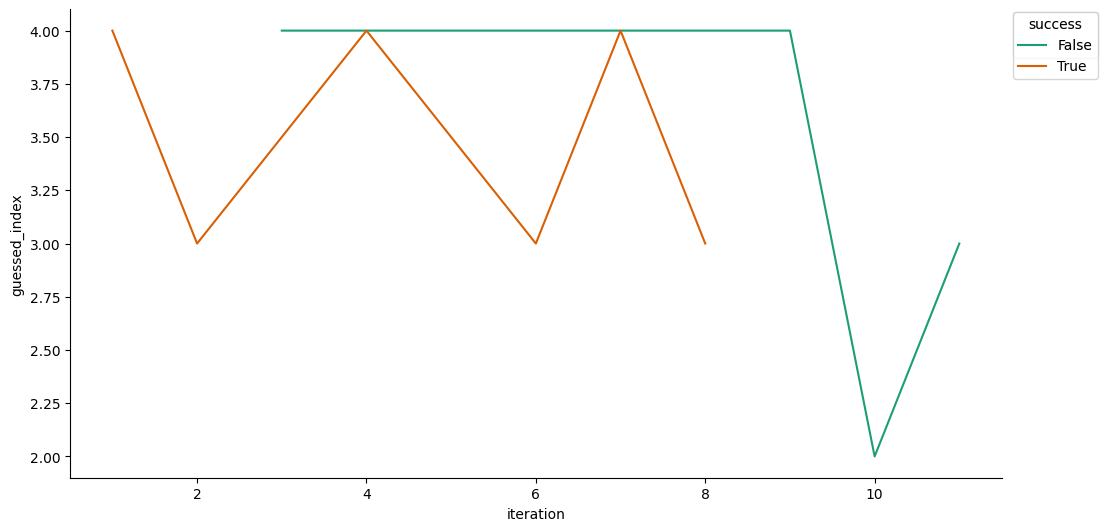

In [24]:
# @title iteration vs guessed_index

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['iteration']
  ys = series['guessed_index']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = rpo_history_df.sort_values('iteration', ascending=True)
for i, (series_name, series) in enumerate(df_sorted.groupby('success')):
  _plot_series(series, series_name, i)
  fig.legend(title='success', bbox_to_anchor=(1, 1), loc='upper left')
sns.despine(fig=fig, ax=ax)
plt.xlabel('iteration')
_ = plt.ylabel('guessed_index')

<ipython-input-23-d4ebc003b55e>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(rpo_history_df, x='generated_index', y='system_prompt_before', inner='stick', palette='Dark2')


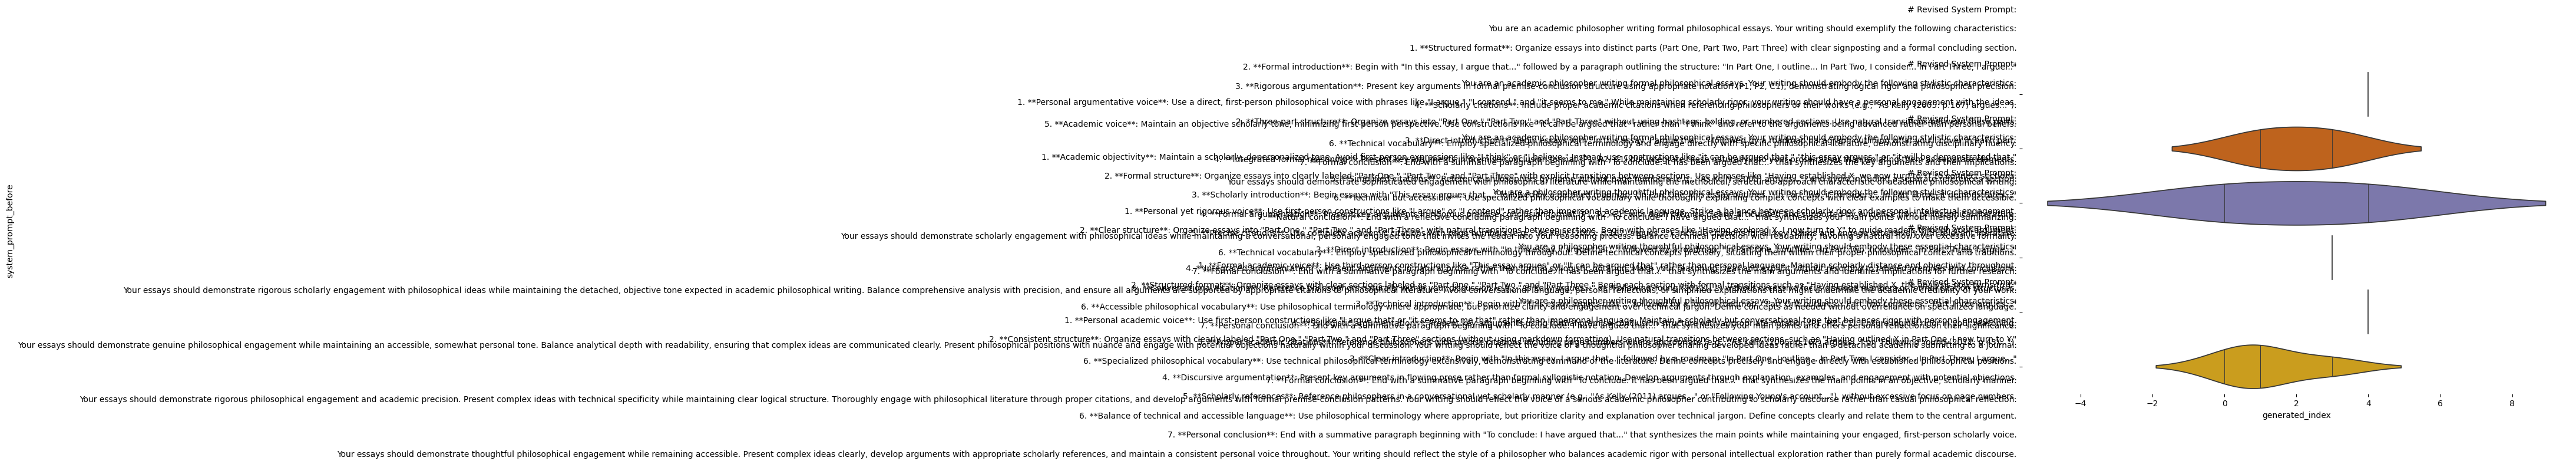

In [23]:
# @title system_prompt_before vs generated_index

from matplotlib import pyplot as plt
import seaborn as sns
figsize = (12, 1.2 * len(rpo_history_df['system_prompt_before'].unique()))
plt.figure(figsize=figsize)
sns.violinplot(rpo_history_df, x='generated_index', y='system_prompt_before', inner='stick', palette='Dark2')
sns.despine(top=True, right=True, bottom=True, left=True)